In [59]:
import sys
sys.path.append('/home/kai/DAST/network')
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import torch.utils.data.dataloader as Data
import os
import time
from torch.autograd import Variable
from DAST_utils import *
from DAST_Network import *
from torch.utils.data import TensorDataset,DataLoader
import sys
from tqdm import tqdm
import math

In [60]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [61]:
#Myscore function
def myScore(target, pred):
    print('target', target.shape)
    print('pred', pred.shape)
    Er = 100 * ((target - pred) / target)
    print(Er.shape)
    A = math.exp(-np.log(0.5) * (Er / 5)) if Er <=0 else math.exp(np.log(0.5) * (Er / 20))
    return A

In [62]:
def RMSE(target, pred):
    square_error = (target - pred) ** 2
    mse =  (torch.sum(square_error)) / len(target)
    rmse = mse ** 0.5
    return rmse

In [63]:
def MAE(target, pred):
    absolute_error = np.abs(target - pred)
    return torch.sum(absolute_error) / len(target)

In [64]:
DATA_PATH = '../../../data/10FEMTO/processed_data/'
FOLDER = 'Bearing1_1'

In [65]:
X_train_1 = np.load(f'{DATA_PATH}/{FOLDER}/{FOLDER}_train_X.npy')
Y_train_1 = np.load(f'{DATA_PATH}/{FOLDER}/{FOLDER}_train_Y.npy')
FOLDER = 'Bearing1_2'
X_train_2 = np.load(f'{DATA_PATH}/{FOLDER}/{FOLDER}_train_X.npy')
Y_train_2 = np.load(f'{DATA_PATH}/{FOLDER}/{FOLDER}_train_Y.npy')
FOLDER = 'Bearing1_4'
X_train_3 = np.load(f'{DATA_PATH}/{FOLDER}/{FOLDER}_train_X.npy')
Y_train_3 = np.load(f'{DATA_PATH}/{FOLDER}/{FOLDER}_train_Y.npy')
FOLDER = 'Bearing1_3'
# Y_train = Y_train.transpose()
X_test = np.load(f'{DATA_PATH}/{FOLDER}/{FOLDER}_test_X.npy')
Y_test = np.load(f'{DATA_PATH}/{FOLDER}/{FOLDER}_test_Y.npy')

In [66]:
Y_train_1 = np.reshape(Y_train_1, (len(Y_train_1), -1))
Y_train_2 = np.reshape(Y_train_2, (len(Y_train_2), -1))
Y_train_3 = np.reshape(Y_train_3, (len(Y_train_3), -1))
Y_test = np.reshape(Y_test, (len(Y_test), -1))

In [67]:
X_train_1.shape

(2763, 40, 20)

In [68]:
X_train = np.concatenate((X_train_1, X_train_2, X_train_3), axis=0)
Y_train = np.concatenate((Y_train_1, Y_train_2, Y_train_3), axis=0)

In [69]:
X_train = Variable(torch.Tensor(X_train_1).float())
Y_train = Variable(torch.Tensor(Y_train_1).float())
X_test = Variable(torch.Tensor(X_test).float())
Y_test = Variable(torch.Tensor(Y_test).float())

In [70]:
#Hyperparameters
batch_size = 256
dim_val = 20
dim_attn = 20
dim_val_t = 20
dim_attn_t = 20
dim_val_s = 20
dim_attn_s = 20
n_heads = 4
n_decoder_layers = 1
n_encoder_layers = 2
lr = 1e-5
epochs = 50
time_step = 40
dec_seq_len = 4
output_sequence_length = 1
input_size = 20

In [71]:
train_dataset = TensorDataset(X_train,Y_train)
train_loader = Data.DataLoader(dataset=train_dataset,batch_size = batch_size,shuffle=False)
test_dataset = TensorDataset(X_test,Y_test)
test_loader = Data.DataLoader(dataset=test_dataset,batch_size = batch_size,shuffle=False)

In [72]:
# Initialize model parameters
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# debug = True
debug = False
model = DAST(dim_val_s,dim_attn_s,dim_val_t,dim_attn_t,dim_val, dim_attn,time_step,input_size,dec_seq_len,output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads, debug)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [73]:
loss_list = []
train_loss_list = []
test_loss_list = []
train_time = []
test_time = []

In [74]:
for epoch in range(epochs):
    #training
    model.train()
    loop = tqdm(train_loader, leave=True)
    for i,(X, Y) in enumerate(loop):
        batch_X = X.to(device)
        batch_Y = Y.to(device)
        out = model(batch_X)
        loss = criterion(out, batch_Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
    loss_eopch = np.mean(np.array(loss_list))
    train_loss_list.append(loss_eopch)
    print('epoch = ',epoch,
            'train_loss = ',loss_eopch.item())

    #testing
    model.eval()
    prediction_list = []
    for j ,(batch_x,batch_y) in enumerate(test_loader):
        batch_X = batch_x.to(device)
        batch_Y = batch_y.to(device)
        prediction = model(batch_X)
        prediction[prediction<0] = 0
        prediction_list.append(prediction)

    out_batch_pre = torch.cat(prediction_list).detach().cpu().numpy()
    prediction_tensor = torch.from_numpy(out_batch_pre)
    rmse_loss = RMSE(Y_test, prediction_tensor, )
    mae_loss = MAE(Y_test, prediction_tensor, )
    print('rmse_loss = ', rmse_loss.item(),
            'mae_loss = ', mae_loss.item())

100%|██████████| 11/11 [00:00<00:00, 30.21it/s]


epoch =  0 train_loss =  0.28994021022861655
rmse_loss =  0.4674127399921417 mae_loss =  0.3850037455558777


100%|██████████| 11/11 [00:00<00:00, 41.01it/s]


epoch =  1 train_loss =  0.2724349613894116
rmse_loss =  0.44997408986091614 mae_loss =  0.3653857707977295


100%|██████████| 11/11 [00:00<00:00, 40.97it/s]


epoch =  2 train_loss =  0.25651332597728027
rmse_loss =  0.431367427110672 mae_loss =  0.3450039029121399


100%|██████████| 11/11 [00:00<00:00, 41.08it/s]


epoch =  3 train_loss =  0.24186971250244163
rmse_loss =  0.41186439990997314 mae_loss =  0.32474687695503235


100%|██████████| 11/11 [00:00<00:00, 41.04it/s]


epoch =  4 train_loss =  0.22838368796828118
rmse_loss =  0.39298537373542786 mae_loss =  0.3062765598297119


100%|██████████| 11/11 [00:00<00:00, 41.04it/s]


epoch =  5 train_loss =  0.2159739093093032
rmse_loss =  0.3744346499443054 mae_loss =  0.2896902859210968


100%|██████████| 11/11 [00:00<00:00, 41.14it/s]


epoch =  6 train_loss =  0.20458604466750638
rmse_loss =  0.35649487376213074 mae_loss =  0.2750413119792938


100%|██████████| 11/11 [00:00<00:00, 40.62it/s]


epoch =  7 train_loss =  0.1941910980121148
rmse_loss =  0.3402923047542572 mae_loss =  0.26252812147140503


100%|██████████| 11/11 [00:00<00:00, 41.08it/s]


epoch =  8 train_loss =  0.1847604824832142
rmse_loss =  0.32643160223960876 mae_loss =  0.2522706389427185


100%|██████████| 11/11 [00:00<00:00, 41.13it/s]


epoch =  9 train_loss =  0.17625766351649708
rmse_loss =  0.31497257947921753 mae_loss =  0.2440158575773239


100%|██████████| 11/11 [00:00<00:00, 41.10it/s]


epoch =  10 train_loss =  0.16862575889157116
rmse_loss =  0.3055948317050934 mae_loss =  0.2374347597360611


100%|██████████| 11/11 [00:00<00:00, 40.97it/s]


epoch =  11 train_loss =  0.16178542606278576
rmse_loss =  0.29780715703964233 mae_loss =  0.23227308690547943


100%|██████████| 11/11 [00:00<00:00, 41.11it/s]


epoch =  12 train_loss =  0.15564758460187203
rmse_loss =  0.29124557971954346 mae_loss =  0.22789064049720764


100%|██████████| 11/11 [00:00<00:00, 41.08it/s]


epoch =  13 train_loss =  0.1501232501204041
rmse_loss =  0.28563201427459717 mae_loss =  0.22409187257289886


100%|██████████| 11/11 [00:00<00:00, 41.11it/s]


epoch =  14 train_loss =  0.14513068686267644
rmse_loss =  0.28073999285697937 mae_loss =  0.22075378894805908


100%|██████████| 11/11 [00:00<00:00, 41.11it/s]


epoch =  15 train_loss =  0.1405991355264136
rmse_loss =  0.2763945162296295 mae_loss =  0.21769621968269348


100%|██████████| 11/11 [00:00<00:00, 41.04it/s]


epoch =  16 train_loss =  0.1364689022053611
rmse_loss =  0.2724912762641907 mae_loss =  0.21487875282764435


100%|██████████| 11/11 [00:00<00:00, 41.10it/s]


epoch =  17 train_loss =  0.13268756404086346
rmse_loss =  0.2689269483089447 mae_loss =  0.21225154399871826


100%|██████████| 11/11 [00:00<00:00, 41.14it/s]


epoch =  18 train_loss =  0.1292094825833822
rmse_loss =  0.2656540870666504 mae_loss =  0.2098182886838913


100%|██████████| 11/11 [00:00<00:00, 41.07it/s]


epoch =  19 train_loss =  0.12599614859050648
rmse_loss =  0.2626228630542755 mae_loss =  0.2075325846672058


100%|██████████| 11/11 [00:00<00:00, 41.15it/s]


epoch =  20 train_loss =  0.12301511854110729
rmse_loss =  0.25977107882499695 mae_loss =  0.2053409069776535


100%|██████████| 11/11 [00:00<00:00, 40.99it/s]


epoch =  21 train_loss =  0.12023758885550721
rmse_loss =  0.2570663094520569 mae_loss =  0.20323492586612701


100%|██████████| 11/11 [00:00<00:00, 40.99it/s]


epoch =  22 train_loss =  0.11763825954817854
rmse_loss =  0.25446435809135437 mae_loss =  0.20114821195602417


100%|██████████| 11/11 [00:00<00:00, 41.05it/s]


epoch =  23 train_loss =  0.11519641111336762
rmse_loss =  0.251968652009964 mae_loss =  0.19908198714256287


100%|██████████| 11/11 [00:00<00:00, 41.19it/s]


epoch =  24 train_loss =  0.11289568200368773
rmse_loss =  0.2496439814567566 mae_loss =  0.19711589813232422


100%|██████████| 11/11 [00:00<00:00, 41.12it/s]


epoch =  25 train_loss =  0.11072233089708261
rmse_loss =  0.24749155342578888 mae_loss =  0.19528204202651978


100%|██████████| 11/11 [00:00<00:00, 41.12it/s]


epoch =  26 train_loss =  0.10866297702759704
rmse_loss =  0.2454439401626587 mae_loss =  0.1935352087020874


100%|██████████| 11/11 [00:00<00:00, 41.15it/s]


epoch =  27 train_loss =  0.10670538608577441
rmse_loss =  0.24344417452812195 mae_loss =  0.19181978702545166


100%|██████████| 11/11 [00:00<00:00, 41.12it/s]


epoch =  28 train_loss =  0.10483968327096357
rmse_loss =  0.2414821982383728 mae_loss =  0.19011647999286652


100%|██████████| 11/11 [00:00<00:00, 41.18it/s]


epoch =  29 train_loss =  0.10305815600705417
rmse_loss =  0.23955759406089783 mae_loss =  0.1884617656469345


100%|██████████| 11/11 [00:00<00:00, 41.03it/s]


epoch =  30 train_loss =  0.10135460469347378
rmse_loss =  0.2376721203327179 mae_loss =  0.1868276298046112


100%|██████████| 11/11 [00:00<00:00, 41.15it/s]


epoch =  31 train_loss =  0.09972299006502991
rmse_loss =  0.23580099642276764 mae_loss =  0.1851954162120819


100%|██████████| 11/11 [00:00<00:00, 41.11it/s]


epoch =  32 train_loss =  0.09815782468417049
rmse_loss =  0.23397623002529144 mae_loss =  0.18363530933856964


100%|██████████| 11/11 [00:00<00:00, 41.01it/s]


epoch =  33 train_loss =  0.09665457163016028
rmse_loss =  0.2322114109992981 mae_loss =  0.1821420043706894


100%|██████████| 11/11 [00:00<00:00, 41.05it/s]


epoch =  34 train_loss =  0.09520913760915592
rmse_loss =  0.23050279915332794 mae_loss =  0.18066728115081787


100%|██████████| 11/11 [00:00<00:00, 33.82it/s]


epoch =  35 train_loss =  0.09381797880338824
rmse_loss =  0.2288292944431305 mae_loss =  0.17923401296138763


100%|██████████| 11/11 [00:00<00:00, 41.09it/s]


epoch =  36 train_loss =  0.09247784894325882
rmse_loss =  0.22719480097293854 mae_loss =  0.17784185707569122


100%|██████████| 11/11 [00:00<00:00, 41.08it/s]


epoch =  37 train_loss =  0.09118565919465925
rmse_loss =  0.22559978067874908 mae_loss =  0.17647771537303925


100%|██████████| 11/11 [00:00<00:00, 41.15it/s]


epoch =  38 train_loss =  0.08993854302053268
rmse_loss =  0.22404547035694122 mae_loss =  0.17516548931598663


100%|██████████| 11/11 [00:00<00:00, 41.06it/s]


epoch =  39 train_loss =  0.0887338922041553
rmse_loss =  0.22254139184951782 mae_loss =  0.1739237755537033


100%|██████████| 11/11 [00:00<00:00, 41.01it/s]


epoch =  40 train_loss =  0.08756931334890904
rmse_loss =  0.22109392285346985 mae_loss =  0.1727377027273178


100%|██████████| 11/11 [00:00<00:00, 41.11it/s]


epoch =  41 train_loss =  0.0864426366343804
rmse_loss =  0.21970222890377045 mae_loss =  0.17161868512630463


100%|██████████| 11/11 [00:00<00:00, 41.03it/s]


epoch =  42 train_loss =  0.08535186661088379
rmse_loss =  0.21836091578006744 mae_loss =  0.17056013643741608


100%|██████████| 11/11 [00:00<00:00, 41.03it/s]


epoch =  43 train_loss =  0.08429514676571077
rmse_loss =  0.21706879138946533 mae_loss =  0.16953641176223755


100%|██████████| 11/11 [00:00<00:00, 41.04it/s]


epoch =  44 train_loss =  0.08327076616273685
rmse_loss =  0.2158202826976776 mae_loss =  0.1685348004102707


100%|██████████| 11/11 [00:00<00:00, 41.17it/s]


epoch =  45 train_loss =  0.0822771568985089
rmse_loss =  0.21461059153079987 mae_loss =  0.16756945848464966


100%|██████████| 11/11 [00:00<00:00, 41.01it/s]


epoch =  46 train_loss =  0.08131279467967135
rmse_loss =  0.21344006061553955 mae_loss =  0.16663658618927002


100%|██████████| 11/11 [00:00<00:00, 41.09it/s]


epoch =  47 train_loss =  0.08037624090811181
rmse_loss =  0.21231576800346375 mae_loss =  0.16573910415172577


100%|██████████| 11/11 [00:00<00:00, 41.14it/s]


epoch =  48 train_loss =  0.07946628530843249
rmse_loss =  0.21122774481773376 mae_loss =  0.16487854719161987


100%|██████████| 11/11 [00:00<00:00, 41.17it/s]


epoch =  49 train_loss =  0.07858178501271389
rmse_loss =  0.21016976237297058 mae_loss =  0.16404925286769867


In [75]:
z = np.reshape(out_batch_pre, (-1))
z = z.tolist()

In [76]:
y = Y_test.detach().cpu().numpy()
y = np.reshape(y, -1)
y = y.tolist()

In [77]:
# z = z[::50]
# y = y[::50]

In [78]:
print(len(z))

2335


In [79]:
print(len(y))

2335


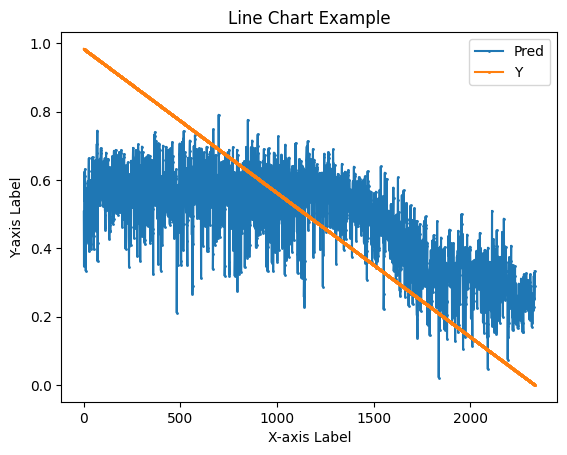

In [58]:
import matplotlib.pyplot as plt

# Example data

# Plotting the line chart
plt.plot(z, label='Pred', marker='o', markersize=1)
plt.plot(y, label='Y', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Line Chart Example')

# Adding a legend
plt.legend()

# Display the plot
plt.show()